In [1]:
!pip install torch-summary
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from typing import Union
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms,datasets
from torchvision.transforms import RandomPerspective,RandomRotation,RandomCrop
from torch.optim.lr_scheduler import ReduceLROnPlateau


from torchsummary import summary
from tqdm import tqdm

SEED = 1
# For reproducibility
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# FULLY CONNECTED LAYER NETWORK
class Net1(nn.Module):
    def __init__(self)->None:
        super(Net1,self).__init__()
        self.fc1 = nn.Linear(in_features=28*28,out_features=128)
        self.fc2 = nn.Linear(in_features=128,out_features=64)
        self.fc3 = nn.Linear(in_features=64,  out_features=16)
        self.fc4 = nn.Linear(in_features=16, out_features=10)
        self.relu = nn.ReLU()

    def forward(self,x):
        x = x.view( x.size(0) , -1 )
        x = self.relu( self.fc1(x) )
        x = self.relu( self.fc2(x) )
        x = self.relu( self.fc3(x) )
        x = self.fc4(x)
        return F.log_softmax(x)


# CONV + FC
class Net2(nn.Module):
    def __init__(self)->None:
        super(Net2,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=32,bias=False,stride=1,kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,bias=False,stride=1,kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=64,out_channels=128,bias=False,stride=1,kernel_size=3)
        self.relu  = nn.ReLU()
        self.pool  = nn.MaxPool2d(kernel_size=2,stride=2)
        self.avg   = nn.AvgPool2d(kernel_size=3)
        self.fc1   = nn.Linear(in_features=128,out_features=64)
        self.fc2   = nn.Linear(in_features=64,out_features=32)
        self.fc3   = nn.Linear(in_features=32,out_features=10)

    def forward(self,x):
        x = self.relu( self.conv1(x)  )  # 28*28*1   > 26*26*32         #k=(3*3*32)
        x = self.pool(x)                 # 26*26*32  > 13*13*32
        x = self.relu( self.conv2(x) )   # 13*13*32  > 11*11*64        #k=(3*3*32 * 64)
        x = self.pool(x)                 # 11*11*64  > 5*5*54
        x = self.relu( self.conv3(x) )   # 5*5*64    > 3*3*128      #k=(3*3*64 *128)
        x = self.avg( x )
        x = x.view( x.size(0) , -1 )
        x = self.fc3( self.relu( self.fc2( self.relu( self.fc1(x) ) ) ) )
        return F.log_softmax(x)


# FULLY CONV GAP - 1*1 Kernel Prediction Layer
class Net3(nn.Module):
    def __init__(self)->None:
        super(Net3,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=32,bias=False,stride=1,kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,bias=False,stride=1,kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=64,out_channels=128,bias=False,stride=1,kernel_size=3)
        self.relu  = nn.ReLU()
        self.pool  = nn.MaxPool2d(kernel_size=2,stride=2)
        self.avg   = nn.AvgPool2d(kernel_size=3)
        self.conv4 = nn.Conv2d(in_channels=128,out_channels=10,bias=False,kernel_size=1)

    def forward(self,x):
        x = self.relu( self.conv1(x)  )  # 28*28*1   > 26*26*32         #k=(3*3*32)
        x = self.pool(x)                 # 26*26*32  > 13*13*32
        x = self.relu( self.conv2(x) )   # 13*13*32  > 11*11*64        #k=(3*3*32 * 64)
        x = self.pool(x)                 # 11*11*64  > 5*5*54
        x = self.relu( self.conv3(x) )   # 5*5*64    > 3*3*128      #k=(3*3*64 *128)
        x = self.avg( x )                # 3*3*128   > 1*1*128
        x = self.conv4(x)
        x = x.view(x.size(0),-1)
        return F.log_softmax(x)



# FULLY CONV - GAP - Prediction Layer
class Net4(nn.Module):
    def __init__(self)->None:
        super(Net4,self).__init__()
        self.relu  = nn.ReLU()
        self.pool  = nn.MaxPool2d(kernel_size=2,stride=2)
        self.avg   = nn.AdaptiveAvgPool2d(1)


        self.conv1 = nn.Conv2d(in_channels=1,out_channels=16,bias=False,stride=1,kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(in_channels=16,out_channels=32,bias=False,stride=1,kernel_size=3,padding=1)
        self.tran1 = nn.Conv2d(in_channels=32,out_channels=16,bias=False,stride=1,kernel_size=1,padding=1)

        self.conv3 = nn.Conv2d(in_channels=16,out_channels=32,bias=False,stride=1,kernel_size=3,padding=1)
        self.conv4 = nn.Conv2d(in_channels=32,out_channels=64,bias=False,stride=1,kernel_size=3,padding=1)
        self.tran2 = nn.Conv2d(in_channels=64,out_channels=16,bias=False,stride=1,kernel_size=1,padding=1)

        self.conv5 = nn.Conv2d(in_channels=16,out_channels=10,bias=False,stride=1,kernel_size=3,padding=1)


    def forward(self,x):
        x = self.pool( self.tran1( self.relu( self.conv2( self.relu( self.conv1(x) ) ) )  ) )
        x = self.pool( self.tran2( self.relu( self.conv4( self.relu( self.conv3(x) ) ) )  ) )
        x = self.conv5(x)
        x = self.avg( x )
        x = x.view(x.size(0),-1)
        return F.log_softmax(x)


# Fully COnv - 1*1 - GAP
class Net5(nn.Module):
    def __init__(self)->None:
        super(Net5,self).__init__()
        self.relu  = nn.ReLU()
        self.pool  = nn.MaxPool2d(kernel_size=2,stride=2)
        self.avg   = nn.AdaptiveAvgPool2d(1)

        self.conv1 = nn.Conv2d(in_channels=1,out_channels=16,bias=False,stride=1,kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(in_channels=16,out_channels=64,bias=False,stride=1,kernel_size=3,padding=1)
        self.tran1 = nn.Conv2d(in_channels=64,out_channels=32,bias=False,stride=1,kernel_size=1,padding=1)

        self.conv3 = nn.Conv2d(in_channels=32,out_channels=128,bias=False,stride=1,kernel_size=3,padding=1)
        self.tran2 = nn.Conv2d(in_channels=128,out_channels=64,bias=False,stride=1,kernel_size=1,padding=1)

        self.conv5 = nn.Conv2d(in_channels=64,out_channels=10,bias=False,stride=1,kernel_size=3,padding=1)


    def forward(self,x):
        x = self.pool( self.tran1( self.relu( self.conv2( self.relu( self.conv1(x) ) ) )  ) )
        x = self.pool( self.tran2(  self.relu( self.conv3(x) ) ) )
        x = self.conv5(x)
        x = self.avg( x )
        x = x.view(x.size(0),-1)
        return F.log_softmax(x)





# Strectch and Squeeze
class Net6(nn.Module):
    def __init__(self):
        super(Net6, self).__init__()
        self.dropout_rate = 0.1

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),# 28*28*1 >26*26*8 RF = 3
            nn.ReLU(),

            nn.Conv2d(in_channels=8, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),# 26*26*8 > 24*24*10, RF = 5
            nn.ReLU(),

        )
        self.trans1 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),  # 24*24*10
            nn.MaxPool2d(kernel_size=(2,2)),  # 24*24*10 > 12*12*10
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=12, kernel_size=(3, 3), padding=0, bias=False), #Op_size = 12*12*10 > 10*10*12
            nn.ReLU(),

            nn.Conv2d(in_channels=12, out_channels=14, kernel_size=(3, 3), padding=0, bias=False), #10*10*12 > 8*8*14
            nn.ReLU(),

            nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),#8*8*14 > 6*6*16
            nn.ReLU(),

            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),#6*6*16 > 4*4*16
            nn.ReLU(),
        )
        self.trans2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),    # 4*4*16 > 4*4*10
        )
        self.gap = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        x = self.trans1( self.conv1(x) )
        x = self.trans2( self.conv2(x) )
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)





# ADDED BATCHNORM
class Net7(nn.Module):
    def __init__(self):
        super(Net7, self).__init__()
        self.dropout_rate = 0.1

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),# 28*28*1 >26*26*8 RF = 3
            nn.BatchNorm2d(8),
            nn.ReLU(),

            nn.Conv2d(in_channels=8, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),# 26*26*8 > 24*24*10, RF = 5
            nn.BatchNorm2d(10),
            nn.ReLU(),

        )
        self.trans1 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),  # 24*24*10
            nn.MaxPool2d(kernel_size=(2,2)),  # 24*24*10 > 12*12*10
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=12, kernel_size=(3, 3), padding=0, bias=False), #Op_size = 12*12*10 > 10*10*12
            nn.BatchNorm2d(12),
            nn.ReLU(),

            nn.Conv2d(in_channels=12, out_channels=14, kernel_size=(3, 3), padding=0, bias=False), #10*10*12 > 8*8*14
            nn.BatchNorm2d(14),
            nn.ReLU(),

            nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),#8*8*14 > 6*6*16
            nn.BatchNorm2d(16),
            nn.ReLU(),

            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),#6*6*16 > 4*4*16
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
        self.trans2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),    # 4*4*16 > 4*4*10
        )
        self.gap = nn.AdaptiveAvgPool2d(1)


    def forward(self, x):
        x = self.trans1( self.conv1(x) )
        x = self.trans2( self.conv2(x) )
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)



# ADDED 0.1 DROPOUT NOT USEFUL
class Net8(nn.Module):
    def __init__(self):
        super(Net8, self).__init__()
        self.dropout_rate = 0.1

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),# 28*28*1 >26*26*8 RF = 3
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Dropout2d(self.dropout_rate),

            nn.Conv2d(in_channels=8, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),# 26*26*8 > 24*24*10, RF = 5
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout2d(self.dropout_rate),

        )
        self.trans1 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),  # 24*24*10
            nn.MaxPool2d(kernel_size=(2,2)),  # 24*24*10 > 12*12*10
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=12, kernel_size=(3, 3), padding=0, bias=False), #Op_size = 12*12*10 > 10*10*12
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.Dropout2d(self.dropout_rate),

            nn.Conv2d(in_channels=12, out_channels=14, kernel_size=(3, 3), padding=0, bias=False), #10*10*12 > 8*8*14
            nn.BatchNorm2d(14),
            nn.ReLU(),
            nn.Dropout2d(self.dropout_rate),

            nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),#8*8*14 > 6*6*16
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout2d(self.dropout_rate),

            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),#6*6*16 > 4*4*16
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout2d(self.dropout_rate),
        )
        self.trans2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),    # 4*4*16 > 4*4*10
        )
        self.gap = nn.AdaptiveAvgPool2d(1)


    def forward(self, x):
        x = self.trans1( self.conv1(x) )
        x = self.trans2( self.conv2(x) )
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)


# Net_81 is same as Net_8 but less Dropouts
# USEFUL 0.01 DROPOUT
class Net8_1(nn.Module):
    def __init__(self):
        super(Net8_1, self).__init__()
        self.dropout_rate = 0.01
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),# 28*28*1 >26*26*8 RF = 3
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Dropout2d(self.dropout_rate),

            nn.Conv2d(in_channels=8, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),# 26*26*8 > 24*24*10, RF = 5
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout2d(self.dropout_rate),
        )
        self.trans1 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),  # 24*24*10
            nn.MaxPool2d(kernel_size=(2,2)),  # 24*24*10 > 12*12*10
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=12, kernel_size=(3, 3), padding=0, bias=False), #Op_size = 12*12*10 > 10*10*12
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.Dropout2d(self.dropout_rate),

            nn.Conv2d(in_channels=12, out_channels=14, kernel_size=(3, 3), padding=0, bias=False), #10*10*12 > 8*8*14
            nn.BatchNorm2d(14),
            nn.ReLU(),
            nn.Dropout2d(self.dropout_rate),

            nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),#8*8*14 > 6*6*16
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout2d(self.dropout_rate),

            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),#6*6*16 > 4*4*16
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout2d(self.dropout_rate),
        )
        self.trans2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),    # 4*4*16 > 4*4*10
        )
        self.gap = nn.AdaptiveAvgPool2d(1)


    def forward(self, x):
        x = self.trans1( self.conv1(x) )
        x = self.trans2( self.conv2(x) )
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)




# INCREASED FILTER IN LAST LAYER
class Net9(nn.Module):
    def __init__(self):
        super(Net9, self).__init__()
        self.dropout_rate = 0.01

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),# 28*28*1 >26*26*8 RF = 3
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Dropout2d(self.dropout_rate),

            nn.Conv2d(in_channels=8, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),# 26*26*8 > 24*24*10, RF = 5
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout2d(self.dropout_rate),

        )
        self.trans1 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),  # 24*24*10
            nn.MaxPool2d(kernel_size=(2,2)),  # 24*24*10 > 12*12*10
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=12, kernel_size=(3, 3), padding=0, bias=False), #Op_size = 12*12*10 > 10*10*12
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.Dropout2d(self.dropout_rate),

            nn.Conv2d(in_channels=12, out_channels=14, kernel_size=(3, 3), padding=0, bias=False), #10*10*12 > 8*8*14
            nn.BatchNorm2d(14),
            nn.ReLU(),
            nn.Dropout2d(self.dropout_rate),

            nn.Conv2d(in_channels=14, out_channels=31, kernel_size=(3, 3), padding=1, bias=False),#8*8*14 > 6*6*16
            nn.BatchNorm2d(31),
            nn.ReLU(),
            nn.Dropout2d(self.dropout_rate),
        )
        self.trans2 = nn.Sequential(
            nn.Conv2d(in_channels=31, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),    # 4*4*16 > 4*4*10
        )
        self.gap = nn.AdaptiveAvgPool2d(1)


    def forward(self, x):
        x = self.trans1( self.conv1(x) )
        x = self.trans2( self.conv2(x) )
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)





# SAME AS NET9 BUT SMALL INCREASE  in CONV1 FILTER INCREASE 10->11
# ABLE TO HIT 99.39
class Net9_3(nn.Module):
    def __init__(self):
        super(Net9_3, self).__init__()
        self.dropout_rate = 0.01

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),# 28*28*1 >26*26*8 RF = 3
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Dropout2d(self.dropout_rate),

            nn.Conv2d(in_channels=8, out_channels=11, kernel_size=(3, 3), padding=0, bias=False),# 26*26*8 > 24*24*10, RF = 5
            nn.BatchNorm2d(11),
            nn.ReLU(),
            nn.Dropout2d(self.dropout_rate),

        )
        self.trans1 = nn.Sequential(
            nn.Conv2d(in_channels=11, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),  # 24*24*10
            nn.MaxPool2d(kernel_size=(2,2)),  # 24*24*10 > 12*12*10
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=12, kernel_size=(3, 3), padding=0, bias=False), #Op_size = 12*12*10 > 10*10*12
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.Dropout2d(self.dropout_rate),

            nn.Conv2d(in_channels=12, out_channels=14, kernel_size=(3, 3), padding=0, bias=False), #10*10*12 > 8*8*14
            nn.BatchNorm2d(14),
            nn.ReLU(),
            nn.Dropout2d(self.dropout_rate),

            nn.Conv2d(in_channels=14, out_channels=31, kernel_size=(3, 3), padding=1, bias=False),#8*8*14 > 6*6*16
            nn.BatchNorm2d(31),
            nn.ReLU(),
            nn.Dropout2d(self.dropout_rate),

            # nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),#6*6*16 > 4*4*16
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout2d(self.dropout_rate),
        )
        self.trans2 = nn.Sequential(
            nn.Conv2d(in_channels=31, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),    # 4*4*16 > 4*4*10
        )
        self.gap = nn.AdaptiveAvgPool2d(1)


    def forward(self, x):
        x = self.trans1( self.conv1(x) )
        x = self.trans2( self.conv2(x) )
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)






def calculate_mnist_mean_std(data_sets):
    '''data_sets: Expected to recieve mnist dataset'''
    mean = torch.zeros(1);
    std=torch.zeros(1);
    total_images  = torch.zeros(1)
    data_loader = DataLoader(data_sets,batch_size=128,shuffle=False)

    for imgs,labels in data_loader:
        batch_size = imgs.shape[0]
        total_images += batch_size

        imgs = imgs.view( batch_size, imgs.size(1), -1 )
        mean += imgs.mean(2).sum()
        std  +=  imgs.std(2).sum()


    mean /= total_images
    std  /= total_images
    print(f'mean of the dataset:- {mean}')
    print(f'std  of the dataset:- {std}')
    return(mean,std)

# mean, std = calculate_mnist_mean_std(mnist_data)



def GetCorrectPredCount(pPrediction, pLabels):
    return pPrediction.argmax(dim=1).eq(pLabels).sum().item()


device = 'cuda'if torch.cuda.is_available() else "cpu"



def plot_loss_accuracy(train_losses, test_losses, train_acc, test_acc):
    fig, axs = plt.subplots(2,2,figsize=(15,10))
    axs[0, 0].plot(train_losses)
    axs[0, 0].set_title("Training Loss")
    axs[1, 0].plot(train_acc)
    axs[1, 0].set_title("Training Accuracy")
    axs[0, 1].plot(test_losses)
    axs[0, 1].set_title("Test Loss")
    axs[1, 1].plot(test_acc)
    axs[1, 1].set_title("Test Accuracy")

In [3]:
if device=='cpu':
  kwargs = {'batch_size': 64, 'shuffle': True}
else:
  kwargs = {'batch_size': 128, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

print(kwargs)

{'batch_size': 128, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}


In [4]:
mnist_data = datasets.MNIST(root='../data/', download=True, transform=transforms.ToTensor() ,)
print(mnist_data)

mean, std = calculate_mnist_mean_std(mnist_data)

100%|██████████| 9912422/9912422 [00:00<00:00, 149164446.71it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 57628779.17it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 32717349.06it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 25848750.02it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data/
    Split: Train
    StandardTransform
Transform: ToTensor()
mean of the dataset:- tensor([0.1307])
std  of the dataset:- tensor([0.3015])


In [5]:
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    pbar = tqdm(train_loader)

    train_loss = 0
    correct = 0
    processed = 0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        # Predict
        pred = model(data)

        # Calculate loss
        loss = criterion(pred, target)
        train_loss+=loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()

        correct += GetCorrectPredCount(pred, target)
        processed += len(data)

        pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

        train_acc.append(100*correct/processed)
        train_losses.append(train_loss/len(train_loader))

    current_train_accuracy = 100*correct/processed
    current_train_loss     = train_loss/len(train_loader)
    return(current_train_accuracy, current_train_loss)



def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    current_test_accuracy = 100. * correct / len(test_loader.dataset)
    current_test_losses   = test_loss
    return (current_test_accuracy, current_test_losses)



In [11]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize( mean=(mean,), std=(std,) )

])

spl_train_transforms = transforms.Compose([
    RandomRotation((-7.0, 7.0), fill=(1,)),
    # RandomPerspective(distortion_scale=0.5, p=0.24),
    transforms.ToTensor(),
    transforms.Normalize( mean=(mean,), std=(std,) )

])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize( mean=(mean,), std=(std,) )
])

# Train DataSet, DataLoader
train_dataset  = datasets.MNIST(root='../../data/',train=True,transform=train_transforms,download=True)
train_loader   = torch.utils.data.DataLoader(train_dataset, **kwargs)


# Test DataSet, DataLoader
test_dataset  = datasets.MNIST(root='../../data/',train=False,transform=test_transforms,download=True)
test_loader   = torch.utils.data.DataLoader(test_dataset, **kwargs)



# APPLIED TRANSFORMS IN DATASET - SPECIAL
strain_dataset = datasets.MNIST(root='../../data/',train=True,transform=spl_train_transforms,download=True)
strain_loader   = torch.utils.data.DataLoader(strain_dataset, **kwargs)

conv1.0.weight		 torch.Size([8, 1, 3, 3])
conv1.1.weight		 torch.Size([8])
conv1.1.bias		 torch.Size([8])
conv1.3.weight		 torch.Size([10, 8, 3, 3])
conv1.4.weight		 torch.Size([10])
conv1.4.bias		 torch.Size([10])
trans1.0.weight		 torch.Size([10, 10, 1, 1])
conv2.0.weight		 torch.Size([12, 10, 3, 3])
conv2.1.weight		 torch.Size([12])
conv2.1.bias		 torch.Size([12])
conv2.3.weight		 torch.Size([14, 12, 3, 3])
conv2.4.weight		 torch.Size([14])
conv2.4.bias		 torch.Size([14])
conv2.6.weight		 torch.Size([16, 14, 3, 3])
conv2.7.weight		 torch.Size([16])
conv2.7.bias		 torch.Size([16])
conv2.9.weight		 torch.Size([16, 16, 3, 3])
conv2.10.weight		 torch.Size([16])
conv2.10.bias		 torch.Size([16])
trans2.0.weight		 torch.Size([10, 16, 1, 1])
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 10, 24, 24]          --
|    └─Conv2d: 2-1                       [-1, 8, 26, 26]           72
|    └─BatchNorm2d: 2-2               

Train: Loss=0.0671 Batch_id=468 Accuracy=94.83: 100%|██████████| 469/469 [00:19<00:00, 24.53it/s]


Test set: Average loss: 0.0570, Accuracy: 9818/10000 (98.18%)

Adjusting learning rate of group 0 to 3.0000e-01.
Epoch 2


Train: Loss=0.0199 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:18<00:00, 25.10it/s]


Test set: Average loss: 0.0409, Accuracy: 9871/10000 (98.71%)

Adjusting learning rate of group 0 to 3.0000e-01.
Epoch 3


Train: Loss=0.0580 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:17<00:00, 26.91it/s]


Test set: Average loss: 0.0348, Accuracy: 9891/10000 (98.91%)

Adjusting learning rate of group 0 to 3.0000e-01.
Epoch 4


Train: Loss=0.0446 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:18<00:00, 25.28it/s]


Test set: Average loss: 0.0309, Accuracy: 9908/10000 (99.08%)

Adjusting learning rate of group 0 to 3.0000e-02.
Epoch 5


Train: Loss=0.0171 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:17<00:00, 26.40it/s]


Test set: Average loss: 0.0215, Accuracy: 9932/10000 (99.32%)

Adjusting learning rate of group 0 to 3.0000e-02.
Epoch 6


Train: Loss=0.0165 Batch_id=468 Accuracy=99.43: 100%|██████████| 469/469 [00:18<00:00, 25.44it/s]


Test set: Average loss: 0.0202, Accuracy: 9934/10000 (99.34%)

Adjusting learning rate of group 0 to 3.0000e-02.
Epoch 7


Train: Loss=0.0019 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:18<00:00, 25.37it/s]


Test set: Average loss: 0.0198, Accuracy: 9940/10000 (99.40%)

Adjusting learning rate of group 0 to 3.0000e-02.
Epoch 8


Train: Loss=0.0027 Batch_id=468 Accuracy=99.49: 100%|██████████| 469/469 [00:17<00:00, 26.62it/s]


Test set: Average loss: 0.0196, Accuracy: 9939/10000 (99.39%)

Adjusting learning rate of group 0 to 3.0000e-03.
Epoch 9


Train: Loss=0.0004 Batch_id=468 Accuracy=99.51: 100%|██████████| 469/469 [00:18<00:00, 25.44it/s]


Test set: Average loss: 0.0193, Accuracy: 9938/10000 (99.38%)

Adjusting learning rate of group 0 to 3.0000e-03.
Epoch 10


Train: Loss=0.0310 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:17<00:00, 26.83it/s]


Test set: Average loss: 0.0195, Accuracy: 9937/10000 (99.37%)

Adjusting learning rate of group 0 to 3.0000e-03.
Epoch 11


Train: Loss=0.0026 Batch_id=468 Accuracy=99.56: 100%|██████████| 469/469 [00:17<00:00, 26.24it/s]


Test set: Average loss: 0.0191, Accuracy: 9937/10000 (99.37%)

Adjusting learning rate of group 0 to 3.0000e-03.
Epoch 12


Train: Loss=0.0913 Batch_id=468 Accuracy=99.56: 100%|██████████| 469/469 [00:17<00:00, 26.80it/s]


Test set: Average loss: 0.0194, Accuracy: 9935/10000 (99.35%)

Adjusting learning rate of group 0 to 3.0000e-04.
Epoch 13


Train: Loss=0.0057 Batch_id=468 Accuracy=99.53: 100%|██████████| 469/469 [00:18<00:00, 25.27it/s]


Test set: Average loss: 0.0194, Accuracy: 9937/10000 (99.37%)

Adjusting learning rate of group 0 to 3.0000e-04.
Epoch 14


Train: Loss=0.0772 Batch_id=468 Accuracy=99.54: 100%|██████████| 469/469 [00:18<00:00, 25.07it/s]


Test set: Average loss: 0.0196, Accuracy: 9938/10000 (99.38%)

Adjusting learning rate of group 0 to 3.0000e-04.
Epoch 15


Train: Loss=0.0080 Batch_id=468 Accuracy=99.56: 100%|██████████| 469/469 [00:17<00:00, 26.77it/s]


Test set: Average loss: 0.0193, Accuracy: 9937/10000 (99.37%)

Adjusting learning rate of group 0 to 3.0000e-04.


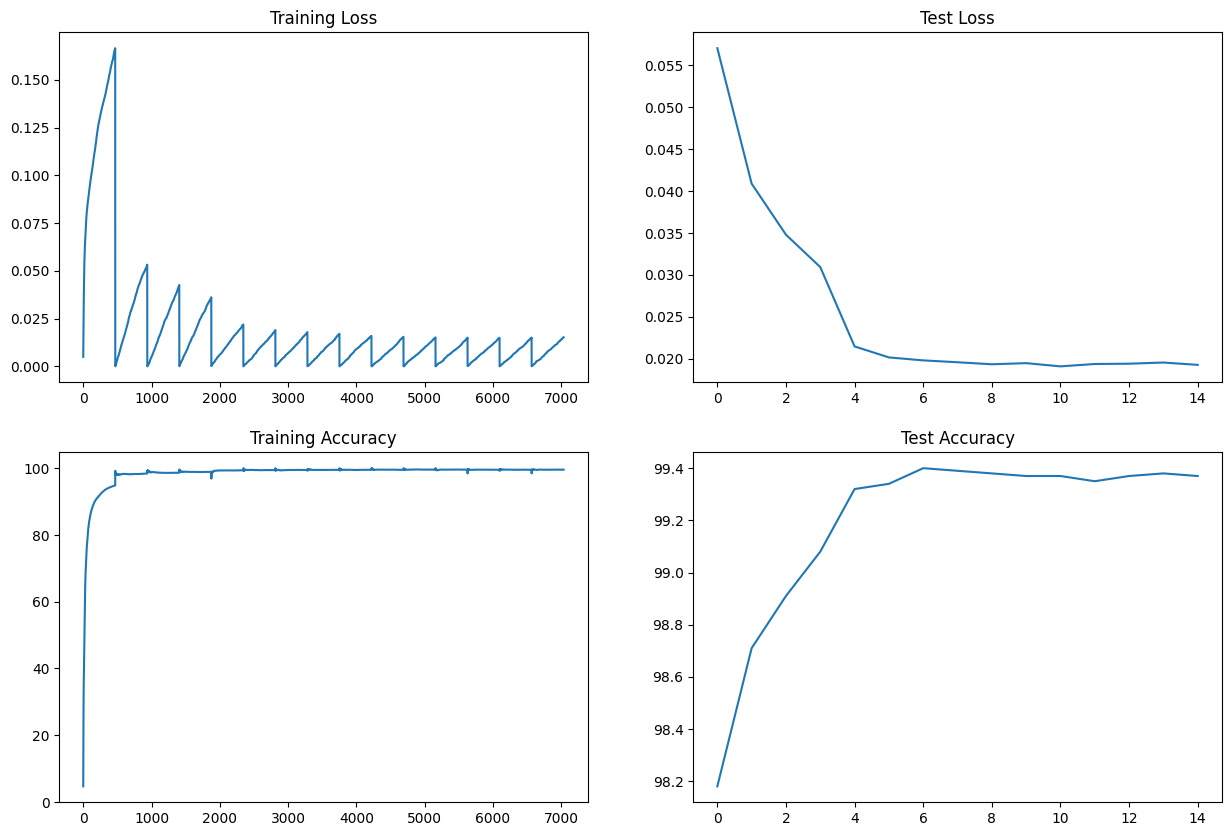

In [7]:
model1 = Net7().to(device)
for name,weights in model1.named_parameters():
    print(f"{name}\t\t {weights.shape}")


summary(model1,(1,28,28));

train_losses = [] ; test_losses = []; train_acc = []; test_acc = []


# SAME MODEL BUT DIFFERNT LR
optimizer = optim.SGD(model1.parameters(), lr=0.3, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1, verbose=True)
criterion = F.nll_loss
num_epochs = 15


for epoch in range(1, num_epochs+1):
    print(f'Epoch {epoch}')
    train_accuracy, train_loss = train(model1, device, train_loader, optimizer, criterion)
    test_accuracy,test_loss    = test(model1, device, test_loader, criterion)
    scheduler.step()


plot_loss_accuracy(train_losses, test_losses, train_acc, test_acc)


conv1.0.weight		 torch.Size([8, 1, 3, 3])
conv1.1.weight		 torch.Size([8])
conv1.1.bias		 torch.Size([8])
conv1.4.weight		 torch.Size([10, 8, 3, 3])
conv1.5.weight		 torch.Size([10])
conv1.5.bias		 torch.Size([10])
trans1.0.weight		 torch.Size([10, 10, 1, 1])
conv2.0.weight		 torch.Size([12, 10, 3, 3])
conv2.1.weight		 torch.Size([12])
conv2.1.bias		 torch.Size([12])
conv2.4.weight		 torch.Size([14, 12, 3, 3])
conv2.5.weight		 torch.Size([14])
conv2.5.bias		 torch.Size([14])
conv2.8.weight		 torch.Size([16, 14, 3, 3])
conv2.9.weight		 torch.Size([16])
conv2.9.bias		 torch.Size([16])
conv2.12.weight		 torch.Size([16, 16, 3, 3])
conv2.13.weight		 torch.Size([16])
conv2.13.bias		 torch.Size([16])
trans2.0.weight		 torch.Size([10, 16, 1, 1])
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 10, 24, 24]          --
|    └─Conv2d: 2-1                       [-1, 8, 26, 26]           72
|    └─BatchNorm2d: 2-2              

Train: Loss=0.0645 Batch_id=468 Accuracy=93.71: 100%|██████████| 469/469 [00:17<00:00, 26.12it/s]


Test set: Average loss: 0.0463, Accuracy: 9850/10000 (98.50%)

Adjusting learning rate of group 0 to 3.0000e-01.
Epoch 2


Train: Loss=0.0532 Batch_id=468 Accuracy=98.04: 100%|██████████| 469/469 [00:18<00:00, 25.96it/s]


Test set: Average loss: 0.0402, Accuracy: 9869/10000 (98.69%)

Adjusting learning rate of group 0 to 3.0000e-01.
Epoch 3


Train: Loss=0.0756 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:17<00:00, 26.61it/s]


Test set: Average loss: 0.0339, Accuracy: 9907/10000 (99.07%)

Adjusting learning rate of group 0 to 3.0000e-01.
Epoch 4


Train: Loss=0.0118 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:18<00:00, 25.30it/s]


Test set: Average loss: 0.0267, Accuracy: 9912/10000 (99.12%)

Adjusting learning rate of group 0 to 3.0000e-02.
Epoch 5


Train: Loss=0.0045 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:18<00:00, 25.09it/s]


Test set: Average loss: 0.0210, Accuracy: 9932/10000 (99.32%)

Adjusting learning rate of group 0 to 3.0000e-02.
Epoch 6


Train: Loss=0.0050 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:18<00:00, 25.62it/s]


Test set: Average loss: 0.0204, Accuracy: 9934/10000 (99.34%)

Adjusting learning rate of group 0 to 3.0000e-02.
Epoch 7


Train: Loss=0.0079 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:17<00:00, 26.73it/s]


Test set: Average loss: 0.0208, Accuracy: 9932/10000 (99.32%)

Adjusting learning rate of group 0 to 3.0000e-02.
Epoch 8


Train: Loss=0.0059 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:17<00:00, 26.58it/s]


Test set: Average loss: 0.0204, Accuracy: 9935/10000 (99.35%)

Adjusting learning rate of group 0 to 3.0000e-03.
Epoch 9


Train: Loss=0.0027 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:18<00:00, 25.09it/s]


Test set: Average loss: 0.0197, Accuracy: 9938/10000 (99.38%)

Adjusting learning rate of group 0 to 3.0000e-03.
Epoch 10


Train: Loss=0.0114 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:17<00:00, 26.56it/s]


Test set: Average loss: 0.0202, Accuracy: 9937/10000 (99.37%)

Adjusting learning rate of group 0 to 3.0000e-03.
Epoch 11


Train: Loss=0.0380 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:19<00:00, 24.64it/s]


Test set: Average loss: 0.0197, Accuracy: 9934/10000 (99.34%)

Adjusting learning rate of group 0 to 3.0000e-03.
Epoch 12


Train: Loss=0.0096 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:18<00:00, 24.74it/s]


Test set: Average loss: 0.0195, Accuracy: 9935/10000 (99.35%)

Adjusting learning rate of group 0 to 3.0000e-04.
Epoch 13


Train: Loss=0.0063 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:17<00:00, 26.78it/s]


Test set: Average loss: 0.0197, Accuracy: 9934/10000 (99.34%)

Adjusting learning rate of group 0 to 3.0000e-04.
Epoch 14


Train: Loss=0.1021 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:18<00:00, 25.18it/s]


Test set: Average loss: 0.0199, Accuracy: 9936/10000 (99.36%)

Adjusting learning rate of group 0 to 3.0000e-04.
Epoch 15


Train: Loss=0.0187 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:17<00:00, 26.34it/s]


Test set: Average loss: 0.0196, Accuracy: 9938/10000 (99.38%)

Adjusting learning rate of group 0 to 3.0000e-04.


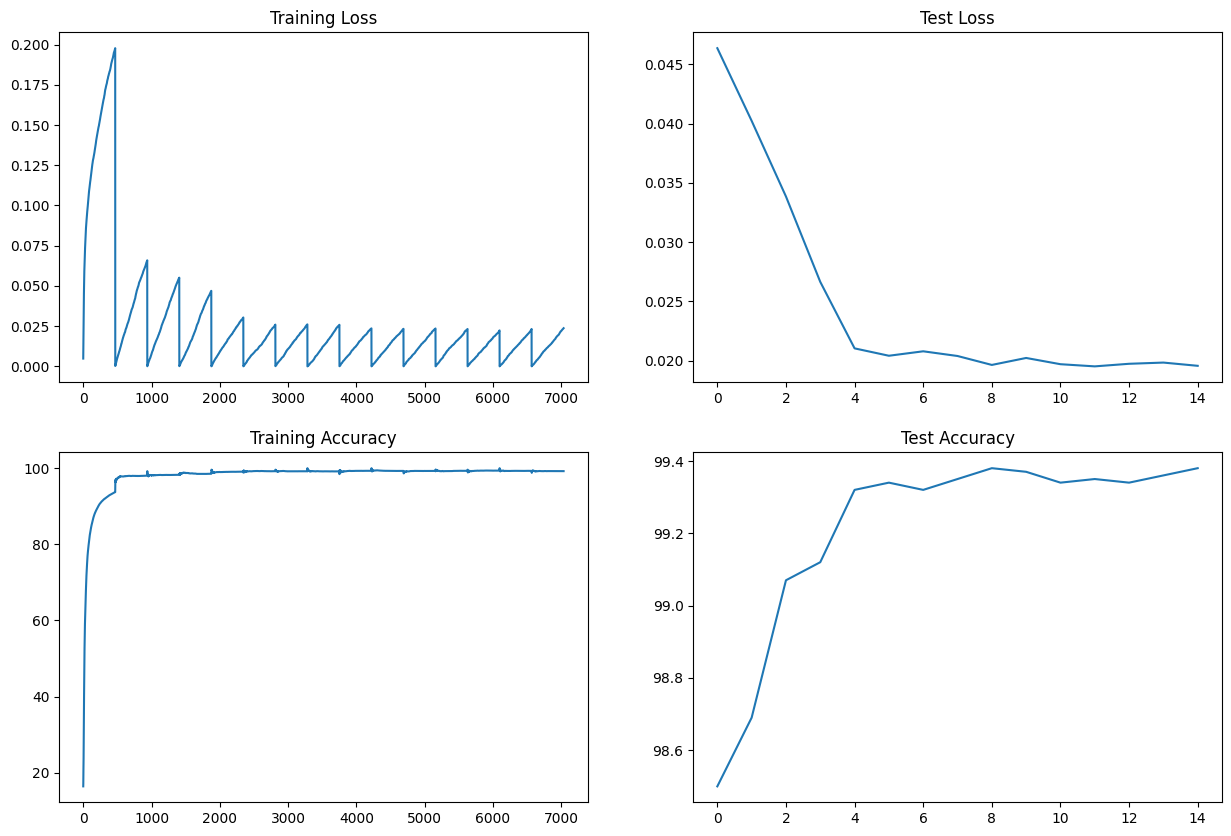

In [8]:
model2 = Net8_1().to(device)
for name,weights in model2.named_parameters():
    print(f"{name}\t\t {weights.shape}")


summary(model2,(1,28,28));

train_losses = [] ; test_losses = []; train_acc = []; test_acc = []


# SAME MODEL BUT DIFFERNT LR
optimizer = optim.SGD(model2.parameters(), lr=0.3, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1, verbose=True)
criterion = F.nll_loss
num_epochs = 15


for epoch in range(1, num_epochs+1):
    print(f'Epoch {epoch}')
    train_accuracy, train_loss = train(model2, device, train_loader, optimizer, criterion)
    test_accuracy,test_loss    = test(model2, device, test_loader, criterion)
    scheduler.step()


plot_loss_accuracy(train_losses, test_losses, train_acc, test_acc)


conv1.0.weight		 torch.Size([8, 1, 3, 3])
conv1.1.weight		 torch.Size([8])
conv1.1.bias		 torch.Size([8])
conv1.4.weight		 torch.Size([11, 8, 3, 3])
conv1.5.weight		 torch.Size([11])
conv1.5.bias		 torch.Size([11])
trans1.0.weight		 torch.Size([10, 11, 1, 1])
conv2.0.weight		 torch.Size([12, 10, 3, 3])
conv2.1.weight		 torch.Size([12])
conv2.1.bias		 torch.Size([12])
conv2.4.weight		 torch.Size([14, 12, 3, 3])
conv2.5.weight		 torch.Size([14])
conv2.5.bias		 torch.Size([14])
conv2.8.weight		 torch.Size([31, 14, 3, 3])
conv2.9.weight		 torch.Size([31])
conv2.9.bias		 torch.Size([31])
trans2.0.weight		 torch.Size([10, 31, 1, 1])
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 11, 24, 24]          --
|    └─Conv2d: 2-1                       [-1, 8, 26, 26]           72
|    └─BatchNorm2d: 2-2                  [-1, 8, 26, 26]           16
|    └─ReLU: 2-3                         [-1, 8, 26, 26]           --
|    └─Dro

Train: Loss=0.0739 Batch_id=468 Accuracy=91.02: 100%|██████████| 469/469 [00:18<00:00, 25.97it/s]


Test set: Average loss: 0.0772, Accuracy: 9786/10000 (97.86%)

Adjusting learning rate of group 0 to 3.0000e-01.
Epoch 2


Train: Loss=0.0948 Batch_id=468 Accuracy=97.52: 100%|██████████| 469/469 [00:18<00:00, 25.80it/s]


Test set: Average loss: 0.0531, Accuracy: 9837/10000 (98.37%)

Adjusting learning rate of group 0 to 3.0000e-01.
Epoch 3


Train: Loss=0.0260 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:17<00:00, 26.36it/s]


Test set: Average loss: 0.0369, Accuracy: 9887/10000 (98.87%)

Adjusting learning rate of group 0 to 3.0000e-01.
Epoch 4


Train: Loss=0.0568 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:19<00:00, 24.44it/s]


Test set: Average loss: 0.0351, Accuracy: 9888/10000 (98.88%)

Adjusting learning rate of group 0 to 3.0000e-02.
Epoch 5


Train: Loss=0.0151 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:17<00:00, 26.71it/s]


Test set: Average loss: 0.0233, Accuracy: 9917/10000 (99.17%)

Adjusting learning rate of group 0 to 3.0000e-02.
Epoch 6


Train: Loss=0.0174 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:17<00:00, 26.20it/s]


Test set: Average loss: 0.0232, Accuracy: 9925/10000 (99.25%)

Adjusting learning rate of group 0 to 3.0000e-02.
Epoch 7


Train: Loss=0.0031 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:18<00:00, 25.92it/s]


Test set: Average loss: 0.0219, Accuracy: 9926/10000 (99.26%)

Adjusting learning rate of group 0 to 3.0000e-02.
Epoch 8


Train: Loss=0.0355 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:17<00:00, 26.67it/s]


Test set: Average loss: 0.0224, Accuracy: 9925/10000 (99.25%)

Adjusting learning rate of group 0 to 3.0000e-03.
Epoch 9


Train: Loss=0.0070 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:18<00:00, 25.14it/s]


Test set: Average loss: 0.0220, Accuracy: 9927/10000 (99.27%)

Adjusting learning rate of group 0 to 3.0000e-03.
Epoch 10


Train: Loss=0.0271 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:17<00:00, 26.78it/s]


Test set: Average loss: 0.0218, Accuracy: 9927/10000 (99.27%)

Adjusting learning rate of group 0 to 3.0000e-03.
Epoch 11


Train: Loss=0.0187 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:18<00:00, 26.01it/s]


Test set: Average loss: 0.0218, Accuracy: 9922/10000 (99.22%)

Adjusting learning rate of group 0 to 3.0000e-03.
Epoch 12


Train: Loss=0.0508 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:18<00:00, 25.06it/s]


Test set: Average loss: 0.0216, Accuracy: 9924/10000 (99.24%)

Adjusting learning rate of group 0 to 3.0000e-04.
Epoch 13


Train: Loss=0.0072 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:17<00:00, 27.09it/s]


Test set: Average loss: 0.0217, Accuracy: 9928/10000 (99.28%)

Adjusting learning rate of group 0 to 3.0000e-04.
Epoch 14


Train: Loss=0.0334 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:18<00:00, 24.85it/s]


Test set: Average loss: 0.0215, Accuracy: 9928/10000 (99.28%)

Adjusting learning rate of group 0 to 3.0000e-04.
Epoch 15


Train: Loss=0.0573 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:17<00:00, 26.81it/s]


Test set: Average loss: 0.0215, Accuracy: 9926/10000 (99.26%)

Adjusting learning rate of group 0 to 3.0000e-04.


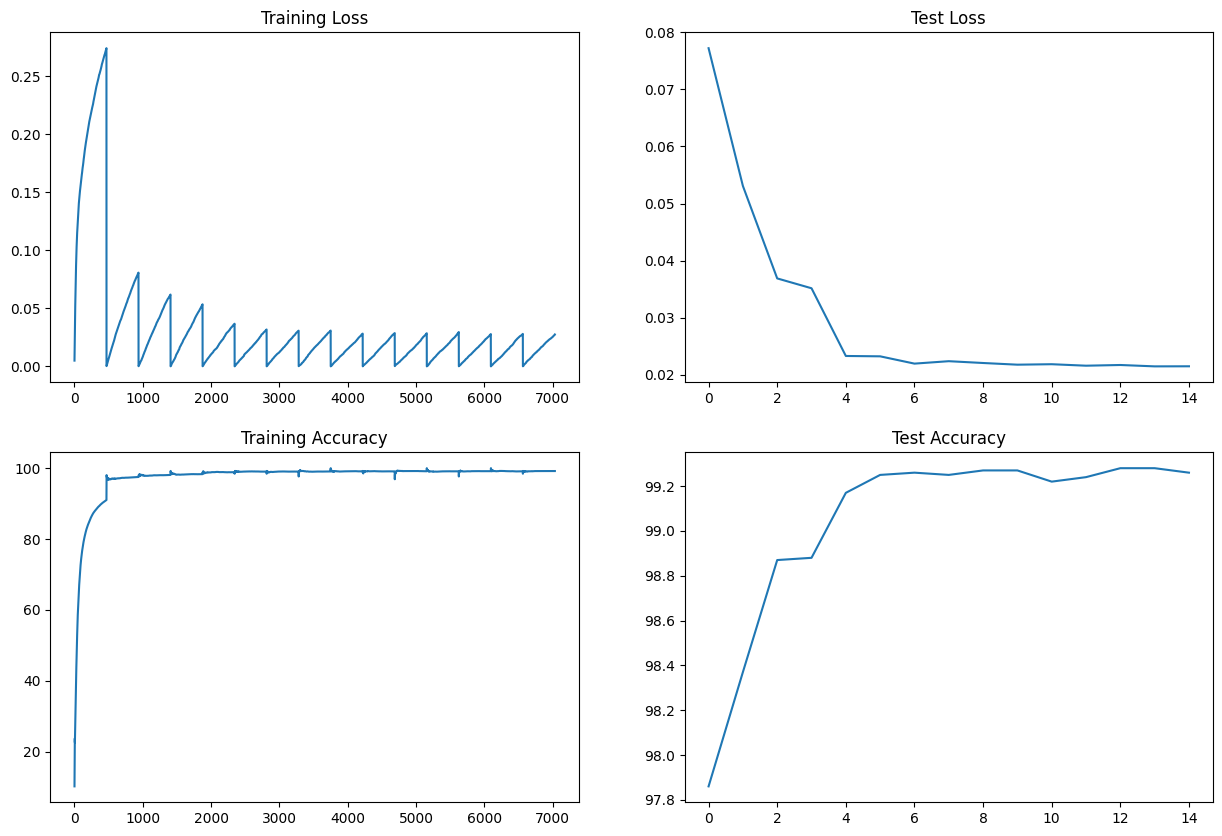

In [9]:
model3 = Net9_3().to(device)
for name,weights in model3.named_parameters():
    print(f"{name}\t\t {weights.shape}")


summary(model3,(1,28,28));

train_losses = [] ; test_losses = []; train_acc = []; test_acc = []


# SAME MODEL BUT DIFFERNT LR
optimizer = optim.SGD(model3.parameters(), lr=0.3, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1, verbose=True)
criterion = F.nll_loss
num_epochs = 15


for epoch in range(1, num_epochs+1):
    print(f'Epoch {epoch}')
    train_accuracy, train_loss = train(model3, device, train_loader, optimizer, criterion)
    test_accuracy,test_loss    = test(model3, device, test_loader, criterion)
    scheduler.step()


plot_loss_accuracy(train_losses, test_losses, train_acc, test_acc)


conv1.0.weight		 torch.Size([8, 1, 3, 3])
conv1.1.weight		 torch.Size([8])
conv1.1.bias		 torch.Size([8])
conv1.4.weight		 torch.Size([11, 8, 3, 3])
conv1.5.weight		 torch.Size([11])
conv1.5.bias		 torch.Size([11])
trans1.0.weight		 torch.Size([10, 11, 1, 1])
conv2.0.weight		 torch.Size([12, 10, 3, 3])
conv2.1.weight		 torch.Size([12])
conv2.1.bias		 torch.Size([12])
conv2.4.weight		 torch.Size([14, 12, 3, 3])
conv2.5.weight		 torch.Size([14])
conv2.5.bias		 torch.Size([14])
conv2.8.weight		 torch.Size([31, 14, 3, 3])
conv2.9.weight		 torch.Size([31])
conv2.9.bias		 torch.Size([31])
trans2.0.weight		 torch.Size([10, 31, 1, 1])
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 11, 24, 24]          --
|    └─Conv2d: 2-1                       [-1, 8, 26, 26]           72
|    └─BatchNorm2d: 2-2                  [-1, 8, 26, 26]           16
|    └─ReLU: 2-3                         [-1, 8, 26, 26]           --
|    └─Dro

Train: Loss=0.1731 Batch_id=468 Accuracy=91.14: 100%|██████████| 469/469 [00:23<00:00, 20.25it/s]


Test set: Average loss: 0.0867, Accuracy: 9733/10000 (97.33%)

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 2


Train: Loss=0.0542 Batch_id=468 Accuracy=97.00: 100%|██████████| 469/469 [00:24<00:00, 19.30it/s]


Test set: Average loss: 0.0692, Accuracy: 9794/10000 (97.94%)

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 3


Train: Loss=0.0962 Batch_id=468 Accuracy=97.56: 100%|██████████| 469/469 [00:23<00:00, 20.29it/s]


Test set: Average loss: 0.0340, Accuracy: 9886/10000 (98.86%)

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 4


Train: Loss=0.0498 Batch_id=468 Accuracy=98.01: 100%|██████████| 469/469 [00:23<00:00, 20.07it/s]


Test set: Average loss: 0.0318, Accuracy: 9892/10000 (98.92%)

Adjusting learning rate of group 0 to 2.0000e-03.
Epoch 5


Train: Loss=0.0070 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:23<00:00, 20.21it/s]


Test set: Average loss: 0.0219, Accuracy: 9919/10000 (99.19%)

Adjusting learning rate of group 0 to 2.0000e-03.
Epoch 6


Train: Loss=0.0328 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:23<00:00, 20.09it/s]


Test set: Average loss: 0.0205, Accuracy: 9933/10000 (99.33%)

Adjusting learning rate of group 0 to 2.0000e-03.
Epoch 7


Train: Loss=0.0321 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:23<00:00, 20.09it/s]


Test set: Average loss: 0.0193, Accuracy: 9934/10000 (99.34%)

Adjusting learning rate of group 0 to 2.0000e-03.
Epoch 8


Train: Loss=0.0383 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:24<00:00, 19.24it/s]


Test set: Average loss: 0.0200, Accuracy: 9927/10000 (99.27%)

Adjusting learning rate of group 0 to 2.0000e-04.
Epoch 9


Train: Loss=0.0338 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:23<00:00, 20.14it/s]


Test set: Average loss: 0.0192, Accuracy: 9928/10000 (99.28%)

Adjusting learning rate of group 0 to 2.0000e-04.
Epoch 10


Train: Loss=0.0194 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:23<00:00, 20.33it/s]


Test set: Average loss: 0.0191, Accuracy: 9933/10000 (99.33%)

Adjusting learning rate of group 0 to 2.0000e-04.
Epoch 11


Train: Loss=0.0070 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:23<00:00, 20.12it/s]


Test set: Average loss: 0.0186, Accuracy: 9931/10000 (99.31%)

Adjusting learning rate of group 0 to 2.0000e-04.
Epoch 12


Train: Loss=0.0677 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:23<00:00, 20.17it/s]


Test set: Average loss: 0.0183, Accuracy: 9933/10000 (99.33%)

Adjusting learning rate of group 0 to 2.0000e-05.
Epoch 13


Train: Loss=0.0109 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:23<00:00, 20.25it/s]


Test set: Average loss: 0.0185, Accuracy: 9929/10000 (99.29%)

Adjusting learning rate of group 0 to 2.0000e-05.
Epoch 14


Train: Loss=0.0247 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:24<00:00, 18.92it/s]


Test set: Average loss: 0.0185, Accuracy: 9935/10000 (99.35%)

Adjusting learning rate of group 0 to 2.0000e-05.
Epoch 15


Train: Loss=0.0690 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:23<00:00, 20.29it/s]


Test set: Average loss: 0.0185, Accuracy: 9932/10000 (99.32%)

Adjusting learning rate of group 0 to 2.0000e-05.


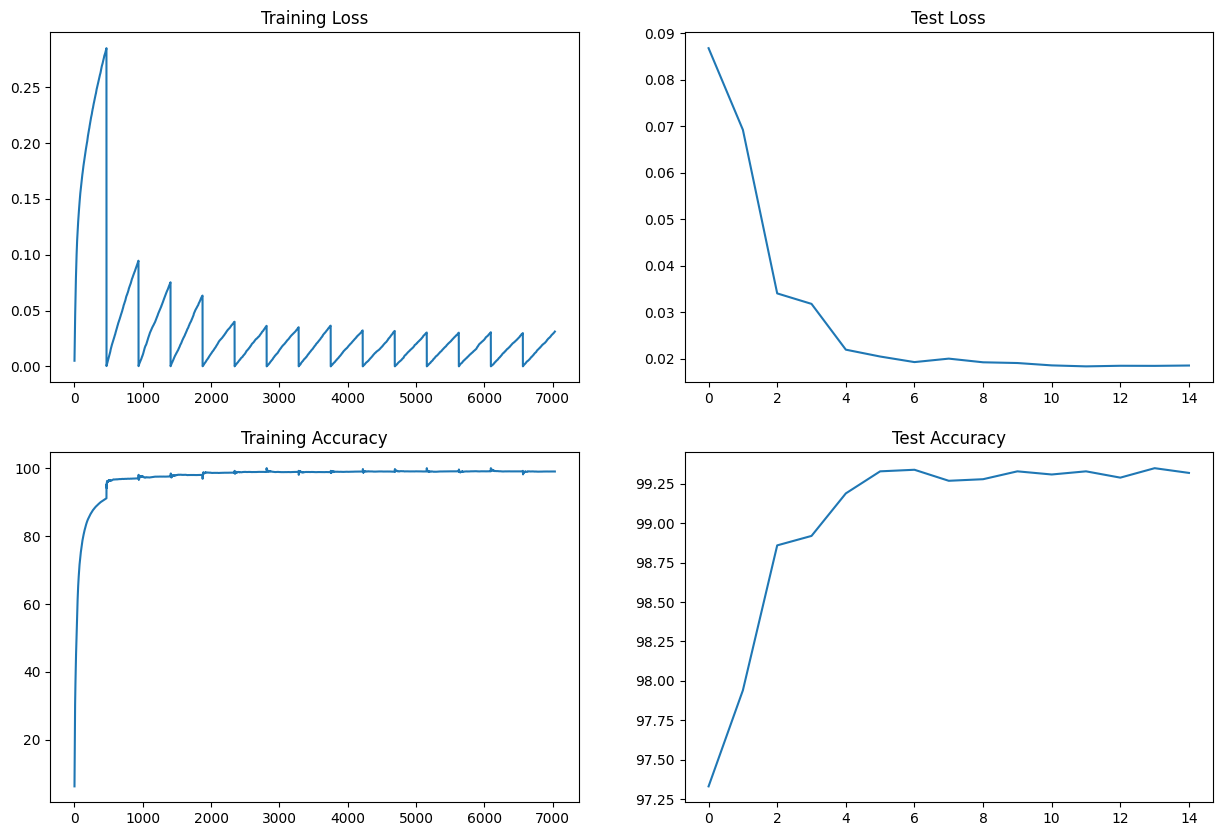

In [12]:
model5 = Net9_3().to(device)
for name,weights in model5.named_parameters():
    print(f"{name}\t\t {weights.shape}")


summary(model5,(1,28,28));

train_losses = [] ; test_losses = []; train_acc = []; test_acc = []


# SAME MODEL BUT DIFFERNT LR
optimizer = optim.Adam(model5.parameters(), lr=0.02)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1, verbose=True)
criterion = F.nll_loss
num_epochs = 15


for epoch in range(1, num_epochs+1):
    print(f'Epoch {epoch}')
    train_accuracy, train_loss = train(model5, device, strain_loader, optimizer, criterion)
    test_accuracy,test_loss    = test(model5, device, test_loader, criterion)
    scheduler.step()


plot_loss_accuracy(train_losses, test_losses, train_acc, test_acc)